# Lesson 5: Understanding of Linear Models, Training Models, Neural Networks and how they work

The purpose of this notebook is to understand the innerworkings of the most basic machine learning frameworks. On top of that, it explores why each step must happen before another.

In [2]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path - Path('../input/titanic')
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [3]:
import torch, numpy as np, pandas as pd, matplotlib.pyplot as plt
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning Up Our Dataset

This dataset is grabbed from this site: https://www.kaggle.com/competitions/titanic 

In [4]:
path = Path('titanic')
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


df is our dataframe which is a kind of table formatted specifically by Pandas  
The code below is looking for the number of non-alphanumerical (null) values. It will then detail a summation amount per each column.

In [5]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Performing a mode calculation of the most common values in the table. Then to make sure you grab the most common will always be stored as the first row going in descending order. This is why to call mode() followed by iloc[] which takes the starting index between [].

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

Taking all the null spaces that create holes in our table and fill them with the most common value in that column. This is one of many techniques of cleaning data for machine learning. The author finds this method the best given how small the dataset is, but recognizes how doing this can affect cause highly inaccurate predictions depending on how volatile changing all null values to common ones.

In [7]:
df.fillna(modes, inplace = True)

In [8]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [9]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Displaying Fare as a histogram shows how skewed or underrespresented the value will be. 

<Axes: >

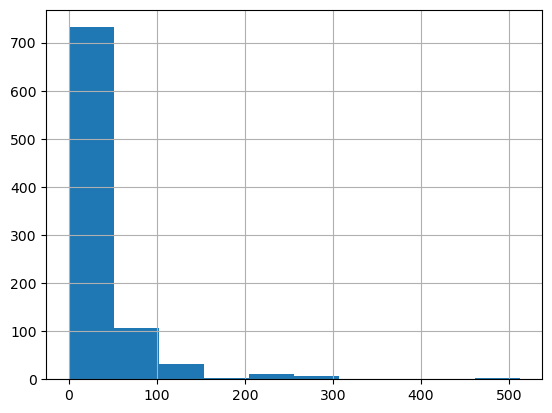

In [10]:
df['Fare'].hist()

It can be said that this value could benefit from modification to help provide a better spread. This could give massive improvements if the value has potential to provide a trend in the data. 

In [11]:
df['LogFare'] = np.log(df['Fare'] + 1)

Sending the Fare through a Log function results in this new histogram that better represents the column we want to predict with

<Axes: >

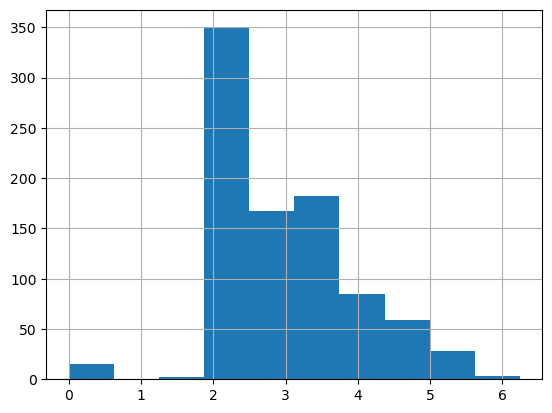

In [12]:
df['LogFare'].hist()

Checking the purpose of Pclass column (They seem to be categories)

In [13]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

Describe shows all non-numeric variables, their count, how many unique ones there are and the top and frequency of the values.

In [14]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,1601,B96 B98,S
freq,1,577,7,691,646


We need to be able to multiply these non-numeric columns by coefficients so we need to make dummy variables of true (1) or false (0) boolean columns

In [15]:
df = pd.get_dummies(df, columns=["Sex", "Pclass", "Embarked"], dtype=float)
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [16]:
added_cols = ['Sex_male', 'Sex_female', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_male,Sex_female,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Creates a tensor matrix of the dependent variable, whether the entry has survived or not

In [17]:
from torch import tensor
t_dep = tensor(df.Survived)

Creates another tensor matrix of the independent variables that we will test with to predict if the entry survived or not. It includes the rows we had to clean such as LogFare(formally Fare), 'Sex_male' and 'Sex_female'(formally Sex), 'Pclass_1', 'Pclass_2' and 'Pclass_3'(formally known as Pclass) and finally 'Embarked_C', 'Embarked_Q' and 'Embarked_S'(formally Embarked).

In [18]:
indep_cols = ['Age','SibSp','Parch','LogFare'] + added_cols

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

Shows you how many rows and columns

In [19]:
t_indep.shape

torch.Size([891, 12])

Tells you the number of (rank) dimensions the tensor has, a vector is rank 1, a matrix is rank 2 

<img src="images/Tensor.png"
     alt="linear ML model outcome" />   

In [20]:
len(t_indep.shape)

2

# Setting up a linear model

We need to multiply our rows of data by coefficients that are randomized and made for each column:    

<img src="images/Example-of-a-linear-ML-model-The-outcome-y-is-predicted-by-the-multiplication-of-feature.png"
     alt="linear ML model outcome" />      

The vector can be understood as a series of weights visually like such:  

<img src="images/Weights.png"
     alt="linear ML model outcome" />

1 Set the seed for the tensor to simulate creating some "random" number generation.  
2 Grabbing the number of coefficients we need to multiply against our matrix.  
3 Generate n_coeff amount of random coefficients between 0 and 1. We subtract 0.5 to center the values so max = 0.5 and min = -0.5.

In [21]:
torch.manual_seed(442) #1

n_coeff = t_indep.shape[1] #2
coeffs = torch.rand(n_coeff) - 0.5 #3
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

We then multiply our matrix to our vector via element-wise multiplication through broadcasting and the use of (*) symbol:
  
<img src="images/Numpy-Broadcasting.png"
     alt="linear ML model outcome" />


Seeing that our Matrix was 861 rows and 12 columns. Our Vector matches to have 12 coefficients that will broadcast that:

- For every coefficient in the vector, each row of the matrix will be mutiplied by that same coefficient based on the index of that column.

- Our vector becomes a matrix with a repeating values for over 861 rows


In [22]:
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.2632,  -0.0000,   0.0000

Since the first column above has a big outputs compared to its other columns, this means when it will be multiplied by its coefficient that it will be significantly impacted differently than the other columns. To fix that we are going to normalize the values by dividing by the maximum value.  

We pass dim = 0 within max to specify that we want the maximum found within the rows and not the columns which would be dim = 1

In [23]:
vals,indices = t_indep.max(dim = 0)
t_indep = t_indep / vals
vals

tensor([80.0000,  8.0000,  6.0000,  6.2409,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000])

We now see that the values are evened out across all columns

In [24]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

axis = 1 specfies that we want to add up our multipied matrix by the columns rather than the rows.  

This is suppose to help determine our predictions as each coefficient in each row is an independent weight that will determine what the dependent variable will result in. For this case its whether or not they survived the titanic

In [25]:
preds = (t_indep*coeffs).sum(axis=1)

The first ten rows of the prediction values

In [26]:
preds[:10]

tensor([ 0.1927, -0.6239,  0.0979,  0.2056,  0.0968,  0.0066,  0.1306,  0.3476,  0.1613, -0.6285])

These initial values are just random and by no means have any ground for being accurate, but they are a starting point to begin the method of gradient descent.  

Here's what that would look like:  

<img src="images/Gradient_Descent.png"
     alt="linear ML model outcome" />  


Cost simply put is performance while weight is the what coefficients you placed for each column that help determine the prediction.  

To determine how much we incrementally step by, we need to create a loss function that calculates how much do we need to alter certain coefficients to hopefully improve the cost.  

One of these ways is through mean absolute value of the calculated prediction - actual prediction as we see below

loss is the calculation of how close our model was to the target. In this case if the person survived or not.

In [27]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5382)

# Create functions to automate and repeat our steps  


These are past code snippets we ran, but now reusable since placed in a function block

In [28]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

# Doing a gradient descent step  

Where does derivatives fit into our idea of gradient descent? It helps to determine in which direction the incremental step will go in. Based on last image above, it makes it seem obvious to know which direction to go in, but not all gradient descents are simply a U shape. Many will have tiny pockets and random bumps that will affect performance and the machine learning model needs to determine which way to head.  

This function sums up the essence of the gradient descent algorithm and the missing piece that is solved in the next piece of code:  

<img src="images/Gradient_Descent_Formula.webp"
     alt="linear ML model outcome" />  


Since we are looking for what's in red and we already know whats in blue. We also know what's in green which is called a learning rate, Something we determine ourselves through trial and error. Now to calculate the derivatives will help determine our missing piece of whats in purple.  

To calculate derivatives automatically, we can call requires_grad_() to perform that but any function with an (_) at the end will update the values  

By calling requires_grad_() on the vector of coefficients, we state to the machine learning model that it is required to store the gradient values for each coefficient at each step. Almost like a recorded history of transactions, that way when we want to tweak the coefficients to get better performance, the model can see the long list of different changes we made and make better calculations.

In [29]:
coeffs.requires_grad_() #pytorch method

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

By requiring that option, when calculating loss we gained the ability to attach the gradient function that stores the gradient values.  

That gradient function is the key towards solving the purple section in the image above.  

To get the result, the solution requires calculating the loss value to now use its value with the function we set to be required to calculate the direction  of fastest increase.


In [30]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5382, grad_fn=<MeanBackward0>)

To call this function we call backward() that will calculate the coefficient gradient values into a variable called grad.

This is necessary because we want our model to learn how to improve its ability to get the correct answer, part of that is going backwards and determining which coefficients we should change and by how much to improve its performance. This is called backpropagation.

In [31]:
loss.backward()

# What do these numbers mean?

The result below of coeffs.grad show what gradient values (aka which coefficients need changing and by how much) for each coefficient used to calculate loss above.  

Positive vs negative values determine which direction the improvement needs to be made while the model needs to determine which gradient values are the largest such that they will have the greatest impact on improving the model

In [32]:
coeffs.grad

tensor([-0.0106,  0.0129, -0.0041, -0.0484,  0.2099, -0.2132, -0.1212, -0.0247,  0.1425, -0.1886, -0.0191,  0.2043])

Taking the gradient values we calculated through backpropagation and multiplying it by a learning rate we chose based on what we think is best will be subtracted from the current coefficients to create new coefficients to test.

The formula from the image above is what this next piece of code performs and this image below describes how this process flows to train our model:  

<img src="images/Simple_Learning_Algorithm.jpg"
     alt="linear ML model outcome" />  


If you now look at what the code block prints out, you will see that it has calculated the new loss value based on the new coefficients created.  

Comparing the two: (old) 0.5382 > (new)0.5197 shows that there was improvement in lowering the loss.

In [33]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5197)


# Training the linear model

Splitting your data for training and validation sets. We import a library that can split our data into these two sets via a random seed that we set.  

For computers there is no real sense of randomness so us setting the seed will give it some sort of randomness.

In [ ]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

The result of the split creates two variables that contain a list of indexes that are chosen for that specific set. The numbers you see printed below the code block are simply which numbers based on their row position were chosen.

In [35]:
val_split

(#178) [303,778,531,385,134,476,691,443,386,128...]

Whats happening below:

1. creating the list of actual row of independent values needed by calling the original dataset and only extracting whats required for each set.
2. performing the same thing for the dependent variable in order to grade performance
3. Grabbing the length of the training and validation sets

In [36]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split] #1
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split] #2
len(trn_indep),len(val_indep) #3

(713, 178)

Taking past code blocks and making them resusable.  

The code function below makes the learning step reusable when training our linear model.

In [37]:
def update_coeffs(coeffs, lr): 
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

This function defines what an Epoch is in machine learning. 

An epoch is when all the training data is used at once and is defined as the total number of iterations of all the training data in one cycle for training the machine learning model  

In our case, its form calculating loss, performing backpropagation, and updating the coefficients through gradient descent and our learning rate.

In [38]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss: .3f}", end="; ")

The function makes creating the inital random variables reusable and this time attaches that the coefficients require the gradient values

In [39]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

This bulky function ties all the previous functions together in a reusable step by step process to train your linear model based on what we created before.
- We set the amount of epochs/times we want to run this process 
- We set the learning rate to increment each time we update the coefficients

In [40]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(434)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr = lr)
    return coeffs

This is the product of all the functions we made by running to train the model on 18 epochs with a learning rate of 0.02  

Our output shows what the loss value of each epoch and how it steadily dropped to its final result of .218

In [41]:
coeffs = train_model(18, lr =0.2)

 0.595;  0.529;  0.477;  0.431;  0.385;  0.349;  0.325;  0.308;  0.299;  0.290;  0.314;  0.277;  0.303;  0.276;  0.290;  0.279;  0.287;  0.278; 

# Successfully Build and Trained a linear model

The block below shows the loss for each coefficients. This gives insight how Age depending on how old, gave you less of a chance at surviving

In [42]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Age': tensor(-0.0526),
 'SibSp': tensor(0.0665),
 'Parch': tensor(-0.2101),
 'LogFare': tensor(-0.3478),
 'Sex_male': tensor(-0.1469),
 'Sex_female': tensor(0.7051),
 'Pclass_1': tensor(0.5845),
 'Pclass_2': tensor(0.4202),
 'Pclass_3': tensor(0.3393),
 'Embarked_C': tensor(0.0497),
 'Embarked_Q': tensor(0.1165),
 'Embarked_S': tensor(0.0920)}

# Measuring accuracy

Mean absolute error as a performance measurement is great but not the only way to measure its performance.  

Accuracy is another way to check for performance by first calculating the predictions like we did once before and storing it in preds

In [43]:
preds = calc_preds(coeffs, val_indep)

This time we take the predictions we made and pass it through a if statement.  

We then create a threshold saying if the predicition is higher than 0.5, then it is True otherwise False. ex. --> (preds > 0.5)  

We then compare the validation set named val_dep that has been passed through bool() which converts the matrix of 0 and 1 into true and false. Comparing it to what prediction was accurately considered true or false based on the threshold.

In [44]:
results = val_dep.bool()==(preds>0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

When we then convert the results matrix into a float so that pytorch can calculate it properly and take the mean we see that the accuracy of this model is .7921 or 79% accurate.

In [45]:
results.float().mean()

tensor(0.7921)

This is now created as a resusable function to test accuracy

In [46]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.7921)

# Using Sigmoid

Looking back on the past predictions made, it shows how some predictions are represented with a negative value or greater than one which isn't all too great when trying to calculate the rate of the dependent variable

In [47]:
preds[:28]

tensor([1.0815, 0.1722, 0.1088, 0.1132, 0.2017, 0.1789, 0.9077, 1.0518, 0.0396, 0.8759, 0.1413, 0.0442, 0.1159, 1.0233, 0.1497, 0.3151,
        0.3020, 0.9821, 0.1559, 0.9894, 0.1468, 0.3079, 1.0240, 0.8905, 0.1550, 0.1216, 0.9699, 0.3039])

Our solution for this problem would to import a mathmatical formula that could squish all possible numbers into a range of 0-1

The sigmoid function is the key to making that happen

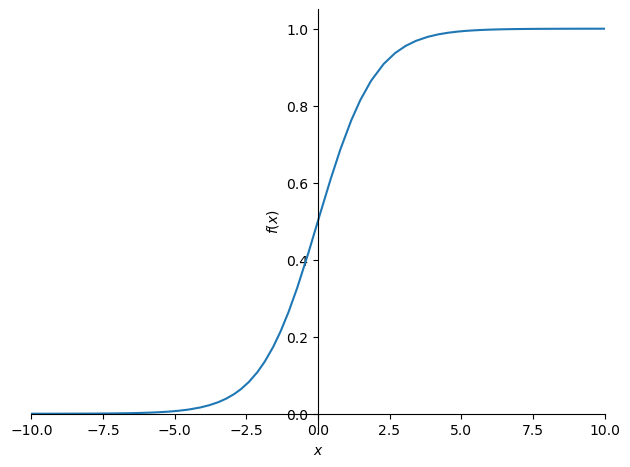

In [48]:
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-10,10));

# Redefine our function

We take our prediction calculation function to now pass the result values through the sigmoid function above to make a more optimized result.  

So that the bigger the number the closer to 1 while the smaller the number the closer its to 0

In [49]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps*coeffs).sum(axis=1))

When retraining the model, the predictions are more in-line between 0 and 1

In [50]:
coeffs = train_model(lr=100)

 0.550;  0.306;  0.209;  0.201;  0.200;  0.198;  0.198;  0.197;  0.197;  0.196;  0.196;  0.196;  0.196;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.195;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194;  0.194; 

Integrating this sigmoid function will not affect the accuracy score at all. Since this dependent variable relies on a binary output, meaning whether survived is yes or no, the sigmoid function is almost necessary to ensure the best results

In [51]:
acc(coeffs)

tensor(0.8258)

In [52]:
show_coeffs()

{'Age': tensor(-1.1117),
 'SibSp': tensor(-1.2590),
 'Parch': tensor(-0.9966),
 'LogFare': tensor(-0.1989),
 'Sex_male': tensor(-8.6799),
 'Sex_female': tensor(7.9411),
 'Pclass_1': tensor(3.2276),
 'Pclass_2': tensor(2.4573),
 'Pclass_3': tensor(-5.6379),
 'Embarked_C': tensor(1.4539),
 'Embarked_Q': tensor(1.9777),
 'Embarked_S': tensor(-4.4705)}

# Improving our processes: 

# Using matrix product

This new symbol @ works similarly to * for Matrix multiplication except that the * is actually element wise multiplication to include broadcasting since it multiplies numbers corresponding to their position in the matrix.  

The @ symbol is the original matrix multiplication that is now replacing the previous iteration that was val_indep*coeffs.sum(axis=1)

In [53]:
(val_indep*coeffs).sum(axis=1)

tensor([ 11.9600, -12.7427, -13.2647, -11.0806, -11.1246, -11.4215,   3.4503,   5.4547, -20.0446,   2.9996, -19.3028, -13.6098, -19.2470,
          3.8778, -19.3250, -10.6539, -10.9318,   5.3093, -11.3401,  -2.6705, -19.1915, -10.8067,  11.6067,   4.6378, -19.1327, -12.9338,
         -2.5843, -10.8901, -19.0969,   3.8782,   5.2615,  -3.6321, -19.1220, -19.2824,  11.8766,  -3.2676, -10.6893,  12.1535, -19.1921,
         -2.7419, -11.0350, -19.1921, -11.6375,  12.0393, -19.1365,  -3.6857, -19.2788, -19.4193, -12.7397,  -2.5403,  -4.5446, -20.1558,
        -19.9860, -19.2022, -11.1322, -11.2156, -12.7428, -19.5354, -19.1504, -19.2749,  -4.5224, -19.2485, -11.1440, -19.1499,   5.0540,
        -10.5197, -11.1107, -19.4331, -13.3088,   5.2173, -19.2193,   3.0025, -11.2017, -19.1968, -10.3613, -19.0799, -19.1921, -10.7520,
        -11.0412, -11.4346, -11.3054,  11.5061, -19.1776, -19.1891,   5.1553,  -5.7253,  -4.5558,   5.8612,  11.2032, -11.0968, -19.3043,
        -19.1921,  12.0566, -13.34

In [54]:
val_indep@coeffs

tensor([ 11.9600, -12.7427, -13.2647, -11.0806, -11.1246, -11.4215,   3.4503,   5.4547, -20.0446,   2.9996, -19.3028, -13.6098, -19.2470,
          3.8778, -19.3250, -10.6539, -10.9318,   5.3093, -11.3401,  -2.6705, -19.1915, -10.8067,  11.6067,   4.6378, -19.1327, -12.9338,
         -2.5843, -10.8901, -19.0969,   3.8782,   5.2615,  -3.6321, -19.1220, -19.2824,  11.8766,  -3.2676, -10.6893,  12.1535, -19.1921,
         -2.7419, -11.0350, -19.1921, -11.6375,  12.0393, -19.1365,  -3.6857, -19.2788, -19.4193, -12.7397,  -2.5403,  -4.5446, -20.1558,
        -19.9860, -19.2022, -11.1322, -11.2156, -12.7428, -19.5354, -19.1504, -19.2749,  -4.5224, -19.2485, -11.1440, -19.1499,   5.0540,
        -10.5197, -11.1107, -19.4331, -13.3088,   5.2173, -19.2193,   3.0025, -11.2017, -19.1968, -10.3613, -19.0799, -19.1921, -10.7520,
        -11.0412, -11.4346, -11.3054,  11.5061, -19.1776, -19.1891,   5.1553,  -5.7253,  -4.5558,   5.8612,  11.2032, -11.0968, -19.3043,
        -19.1921,  12.0566, -13.34

# Simplifying function we had before to implement sigmoid

In [55]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

Updating this one slightly to add not only an n_coeff length vector of coefficients, but now it is a matrix with its dimesnsions as n_coeff x 1 

In [56]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

trn_dep and val_dep are technically vectors and not recognized as matrices. Because of this, performing matrix multiplication between a vector and a matrix will not produce a matrix.  

Reformatting these vectors to matrices to have defined 1 "column" is really the same how a vector is just one column with a given amount of rows.  

This format is only possible through the code syntax below as the key word None after the comma specifies that another row is needed but nothing will fill its space. This effectively makes a matrix equivalent to a vector. (Vectors are still technically matrices but computers are weird)

In [57]:
trn_dep = trn_dep[:, None]
val_dep = val_dep[:, None]


In [58]:
trn_dep.shape

torch.Size([713, 1])

Re-run our training model to test if our results stayed the same with this new change

In [59]:
coeffs = train_model(lr=10)

 0.517;  0.346;  0.301;  0.276;  0.261;  0.251;  0.245;  0.240;  0.236;  0.233;  0.231;  0.229;  0.227;  0.226;  0.225;  0.224;  0.223;  0.222;  0.221;  0.220;  0.219;  0.219;  0.218;  0.218;  0.217;  0.216;  0.216;  0.215;  0.215;  0.215; 

Noticed a slight increase in accuracy from the last run

In [60]:
acc(coeffs)

tensor(0.8371)

Taking note that since our vector change, the output of the coefficients has updated to also a matrix of 12 x 1

In [61]:
coeffs

tensor([[-0.4400],
        [-0.4568],
        [-0.2386],
        [ 0.1695],
        [-3.7836],
        [ 3.4341],
        [ 1.0979],
        [ 0.8266],
        [-2.1455],
        [ 0.3479],
        [ 0.5392],
        [-1.2166]], requires_grad=True)

In [62]:
coeffs.shape

torch.Size([12, 1])

# A Neural Network

<img src="images/neural_network-1024x707.webp"
     alt="linear ML model outcome" />  

The image above is a visual representation of how a neural network works.  

The input layer is just they way the computer hands the data to the first "hidden" layer.  
A layer is just those column/s of coefficients created randomly that will be tested, calculated for loss, updated and recalculated till deemed fit.  
What makes it "hidden" comes from not having to directly interact with it, but allowed to run behind the scenes.  
The image contains two hidden layers but anyone can increase the amount to what they require, that just means to create more rows of coefficients.  

The more complex your data results in the more coefficients in your rows, the more factors in play for your dependent variable the more layers are needed. Of course increasing one aspect of the neural network will cause an increase in all aspects.


  
The function states that 20 columns of coefficients is specified for the hidden layers are going to be created(In this example its just one), the values for those 20 columns of coefficients are normalized by keeping their range between -0.5 to 0.5. To make sure the values also dont jump in value the next matrix multiplication, dividing by n_hidden keeps them low enough.
  
Layer 2 variable is there to create the coefficients needed to multiply against the matrix just created. This process is similar to this -> torch.rand(n_coeff, 1)*0.1).requires_grad_() where torch.rand(n_coeff,1) is now what layer 1 variable is doing while the *0.1 now needs to be handled by layer 2.  

With all neural networks is customary to create a random constant term to ensure some sort of result is outputted in case of error so the const variable is created as a scalar vector

In [63]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.5)/n_hidden # based on image, process is input layer to hidden layers
    layer2 = torch.rand(n_hidden, 1)-0.3 # based on the image, process leads from the hidden layers to one output
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_() # returns a tuple - a list of values that are finite and unable to be changed

If above did not make much sense, the update to the next method explains better on how the process now works.  

This is what calc_preds(coeffs, indeps) did previously:  
```
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

```  

The process for matrix multiplication is slightly more complicated than just mutliplying a single column of coefficients to the independent variable matrix.  
Now the process within calc_preds goes in this order:
- separate the output of coeffs into three variables of l2, l2, const. (these correspond to the order that is outputted by init_coeffs above)
- the result variable is created and now the first matrix multiplication begins with the independent variable matrix and layer 1 and its hidden layers (also relu() replaces any negatives with zeros since its the activiation function)
- Now perform the second matrix mutliply for the final layer of the neural network to output a single value and add it with the const
- apply sigmoid to balance it and return its accuracy.

In [64]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

The code above executes the bulk of what an epoch would perform and now the newly updated update_coeffs function has to account for multiple columns considered as layers to be updated based on what their gradient values were calculated as, then all are then multiplied by a specified learning rate.  

consider this process as a whole rather than individual parts because its essentially the same as how it was performed previously with only one column of coefficients. 

In [65]:
def update_coeffs(coeffs, lr):
    for layer in coeffs: 
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

train_model needed no update to keep up with its counterparts since train_model only provides the order of operations for other functions

In [66]:
coeffs = train_model(epochs= 50,lr=3)

 0.560;  0.546;  0.532;  0.509;  0.480;  0.442;  0.390;  0.330;  0.285;  0.260;  0.245;  0.236;  0.230;  0.226;  0.223;  0.221;  0.219;  0.217;  0.215;  0.214;  0.212;  0.211;  0.210;  0.209;  0.208;  0.207;  0.206;  0.206;  0.205;  0.204;  0.204;  0.203;  0.203;  0.202;  0.202;  0.201;  0.201;  0.201;  0.200;  0.200;  0.200;  0.199;  0.199;  0.199;  0.199;  0.198;  0.198;  0.198;  0.198;  0.198; 

From the training it appears that despite upgrading from a linear model to neural network that the accuracy has not improved. This may happen from tim to time and for a number of factors. In this case the dataset is very small and simple so the neural network cannot be fully utilized. On top of that, it affects how small our validation set to calculate accuracy so that also comes into play.

In [67]:
acc(coeffs)

tensor(0.8258)

# Deep Learning

We are increasing the hidden layers from just one, to n number of layers

In [68]:
def init_coeffs():
    hiddens = [10, 10] # <- set this to the size of each hidden layer that you would want
    sizes = [n_coeff] + hiddens + [1] # sizes now equals the number of required coefficients + the number of hidden layers set + 1 creating the new matrix
    n = len(sizes) # Gets the new length based on new hidden layer requirements
    print(n)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.5)/sizes[i+1]*4 for i in range(n-1)] # calculate based on the range between 0 to n-1, the random number generated from (index at i and i + 1) - 0.3 / index i +1*4
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

init_coeffs()

4


([tensor([[     0.0597,     -0.1089,     -0.1872,      0.1503,      0.0349,      0.0843,      0.0638,     -0.1305,      0.0323,      0.1657],
          [    -0.1835,      0.0139,     -0.1497,      0.0631,     -0.1032,      0.1773,      0.0145,     -0.1507,      0.0144,     -0.0591],
          [     0.0761,     -0.1209,      0.0845,     -0.0227,      0.1019,      0.0859,     -0.1904,     -0.1003,      0.1576,     -0.1862],
          [     0.0196,      0.0991,      0.0810,      0.0736,     -0.0344,     -0.1892,      0.0950,     -0.1968,     -0.1044,      0.1909],
          [     0.0753,      0.0645,      0.0397,     -0.0046,      0.1985,     -0.1713,     -0.1519,      0.1284,     -0.0721,      0.0447],
          [    -0.1499,      0.1185,     -0.1389,     -0.1115,     -0.1626,      0.0146,      0.0188,     -0.1037,      0.1803,     -0.1398],
          [     0.1310,     -0.0644,      0.0780,     -0.1676,     -0.1036,     -0.1120,     -0.1389,      0.0547,     -0.1469,     -0.1534],
      

In [69]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers, consts = coeffs
    n = len(layers)
    res = indeps
    for i, l in enumerate(layers): # loops all the layers of the matrix
        res = res@l + consts[i]  # performs matrix multiplication then adds the constant
        if i!= n-1: res = F.relu(res) # perform relu as long as its not the last layer
    return torch.sigmoid(res) # if last layer then perform the final sigmoid function



In [70]:
# After training the coefficients need to be updated based on their work
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts: layer.sub_(layer.grad * lr)

In [71]:
coeffs = train_model(lr=1.4)

4
 0.514;  0.496;  0.486;  0.471;  0.453;  0.434;  0.416;  0.403;  0.393;  0.387;  0.384;  0.381;  0.380;  0.380;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379;  0.379; 

In [72]:
acc(coeffs)

tensor(0.5955)

Stopped at 1:09:48